In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
from sqlalchemy import create_engine

## Loading in dataset from PostgreSQL

In [3]:
host = r'127.0.0.1'
db = r'MSDS610'
user = r'postgres'
pw = r'MacMVP2025$' 
port = r'5432'

In [4]:
db_conn = create_engine("postgresql://{}:{}@{}:{}/{}".format(user, pw, host, port, db))

In [5]:
table_name = r'real_estate_clean'
schema = r'cleaned'

real_estate4 = pd.read_sql_table(table_name, db_conn, schema)

#### I'm going to quickly confirm I've got the right data

In [6]:
real_estate4.head()

,Serial Number,List Year,Property Type,Non Use Code
0,220008,2022,Residential,None
1,2020348,2020,Commercial,None
2,20002,2020,Residential,None
3,210317,2021,Residential,None
4,200212,2020,Residential,None


### Looks good!

### Analytical question: Identify which features are most closely correlated with foreclosure.

In [7]:
real_estate4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097629 entries, 0 to 1097628
Data columns (total 4 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Serial Number  1097629 non-null  int64 
 1   List Year      1097629 non-null  int64 
 2   Property Type  715183 non-null   object
 3   Non Use Code   313451 non-null   object
dtypes: int64(2), object(2)
memory usage: 33.5+ MB


In [8]:
real_estate4['Property Type'].value_counts()

Property Type
Single Family     401612
Residential       151064
Condo             105420
Two Family         26408
Three Family       12586
Vacant Land         7824
Commercial          5987
Four Family         2150
Apartments          1327
Industrial           795
Public Utility        10
Name: count, dtype: int64

In [9]:
real_estate4 = real_estate4[real_estate4['Property Type'] != 'Commercial']
real_estate4 = real_estate4[real_estate4['Property Type'] != 'Public Utility']
real_estate4 = real_estate4[real_estate4['Property Type'] != 'Industrial']
real_estate4 = real_estate4[real_estate4['Property Type'] != 'Vacant Land']
real_estate4 = real_estate4[real_estate4['Property Type'] != 'Four Family']
real_estate4 = real_estate4[real_estate4['Property Type'] != 'Three Family']
real_estate4 = real_estate4[real_estate4['Property Type'] != 'Two Family']


real_estate4.head()

,Serial Number,List Year,Property Type,Non Use Code
0,220008,2022,Residential,None
2,20002,2020,Residential,None
3,210317,2021,Residential,None
4,200212,2020,Residential,None
5,200243,2020,Residential,None


In [10]:
real_estate4.shape

(1041869, 4)

In [11]:
Non_use_entries = real_estate4['Non Use Code'].value_counts()
Non_use_entries

Non Use Code
25 - Other                 58350
14 - Foreclosure           46177
07 - Change in Property    38466
7.0                        18785
08 - Part Interest         15400
                           ...  
55.0                           1
38.0                           1
68.0                           1
33.0                           1
75                             1
Name: count, Length: 105, dtype: int64

In [12]:
real_estate4['Non Use Code'] = real_estate4['Non Use Code'].apply(lambda x: 1 if x == '14 - Foreclosure' else 0)
real_estate4.head(15)

,Serial Number,List Year,Property Type,Non Use Code
0,220008,2022,Residential,0
2,20002,2020,Residential,0
3,210317,2021,Residential,0
4,200212,2020,Residential,0
5,200243,2020,Residential,0
6,200377,2020,Residential,0
7,22043,2022,Residential,0
8,200109,2020,Residential,0
9,2020180,2020,Residential,0
10,2020313,2020,Residential,0


In [13]:
real_estate4['Non Use Code'] = real_estate4['Non Use Code'].astype(float)

In [14]:
real_estate4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1041869 entries, 0 to 1097628
Data columns (total 4 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   Serial Number  1041869 non-null  int64  
 1   List Year      1041869 non-null  int64  
 2   Property Type  659423 non-null   object 
 3   Non Use Code   1041869 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 39.7+ MB


In [15]:
real_estate4['Non Use Code'].value_counts()

Non Use Code
0.0    995692
1.0     46177
Name: count, dtype: int64

In [16]:
real_estate4 = real_estate4.drop(columns=['Serial Number'])

In [17]:
old_data = pd.read_csv('Real_Estate_Sales_2001-2022_GL.csv')
old_data.head()


/var/folders/3d/nb6n2ch91816p9ksz49h0wx00000gn/T/ipykernel_10990/3746828940.py:1: DtypeWarning: Columns (8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  old_data = pd.read_csv('Real_Estate_Sales_2001-2022_GL.csv')


,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Non Use Code,Assessor Remarks,OPM remarks,Location
0,220008,2022,01/30/2023,Andover,618 ROUTE 6,139020.0,232000.0,0.5992,Residential,Single Family,NaN,NaN,NaN,POINT (-72.343628962 41.728431984)
1,2020348,2020,09/13/2021,Ansonia,230 WAKELEE AVE,150500.0,325000.0,0.4630,Commercial,NaN,NaN,NaN,NaN,NaN
2,20002,2020,10/02/2020,Ashford,390 TURNPIKE RD,253000.0,430000.0,0.5883,Residential,Single Family,NaN,NaN,NaN,NaN
3,210317,2021,07/05/2022,Avon,53 COTSWOLD WAY,329730.0,805000.0,0.4096,Residential,Single Family,NaN,NaN,NaN,POINT (-72.846365959 41.781677018)
4,200212,2020,03/09/2021,Avon,5 CHESTNUT DRIVE,130400.0,179900.0,0.7248,Residential,Condo,NaN,NaN,NaN,NaN


In [18]:
real_estate4['Assessed Value'] = old_data['Assessed Value']
real_estate4['Sale Amount'] = old_data['Sale Amount']

real_estate4.head()

,List Year,Property Type,Non Use Code,Assessed Value,Sale Amount
0,2022,Residential,0.0,139020.0,232000.0
2,2020,Residential,0.0,253000.0,430000.0
3,2021,Residential,0.0,329730.0,805000.0
4,2020,Residential,0.0,130400.0,179900.0
5,2020,Residential,0.0,619290.0,890000.0


In [19]:
real_estate4['Sales Ratio'] = real_estate4['Assessed Value'] / (real_estate4['Sale Amount'])
real_estate4.head() 

,List Year,Property Type,Non Use Code,Assessed Value,Sale Amount,Sales Ratio
0,2022,Residential,0.0,139020.0,232000.0,0.599224
2,2020,Residential,0.0,253000.0,430000.0,0.588372
3,2021,Residential,0.0,329730.0,805000.0,0.409602
4,2020,Residential,0.0,130400.0,179900.0,0.724847
5,2020,Residential,0.0,619290.0,890000.0,0.695831


In [20]:
real_estate4['Overpriced'] = (real_estate4['Sales Ratio'] < 0.65).astype(int)
real_estate4.head()

,List Year,Property Type,Non Use Code,Assessed Value,Sale Amount,Sales Ratio,Overpriced
0,2022,Residential,0.0,139020.0,232000.0,0.599224,1
2,2020,Residential,0.0,253000.0,430000.0,0.588372,1
3,2021,Residential,0.0,329730.0,805000.0,0.409602,1
4,2020,Residential,0.0,130400.0,179900.0,0.724847,0
5,2020,Residential,0.0,619290.0,890000.0,0.695831,0


In [21]:
real_estate4 = real_estate4.drop(columns=['Property Type'])
real_estate4.head()

,List Year,Non Use Code,Assessed Value,Sale Amount,Sales Ratio,Overpriced
0,2022,0.0,139020.0,232000.0,0.599224,1
2,2020,0.0,253000.0,430000.0,0.588372,1
3,2021,0.0,329730.0,805000.0,0.409602,1
4,2020,0.0,130400.0,179900.0,0.724847,0
5,2020,0.0,619290.0,890000.0,0.695831,0


In [22]:
real_estate4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1041869 entries, 0 to 1097628
Data columns (total 6 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   List Year       1041869 non-null  int64  
 1   Non Use Code    1041869 non-null  float64
 2   Assessed Value  1041869 non-null  float64
 3   Sale Amount     1041869 non-null  float64
 4   Sales Ratio     1041583 non-null  float64
 5   Overpriced      1041869 non-null  int64  
dtypes: float64(4), int64(2)
memory usage: 55.6 MB


In [23]:
sampled_df = real_estate4.sample(n=1200)


In [24]:
import sklearn

In [25]:
X = sampled_df.drop(columns=['Non Use Code'])
y = sampled_df['Non Use Code']

In [26]:
 X = X.rename(str,axis="columns") 

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
classi = RandomForestClassifier(n_estimators=100, random_state=42)
classi.fit(X_train, y_train)

importances = classi.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

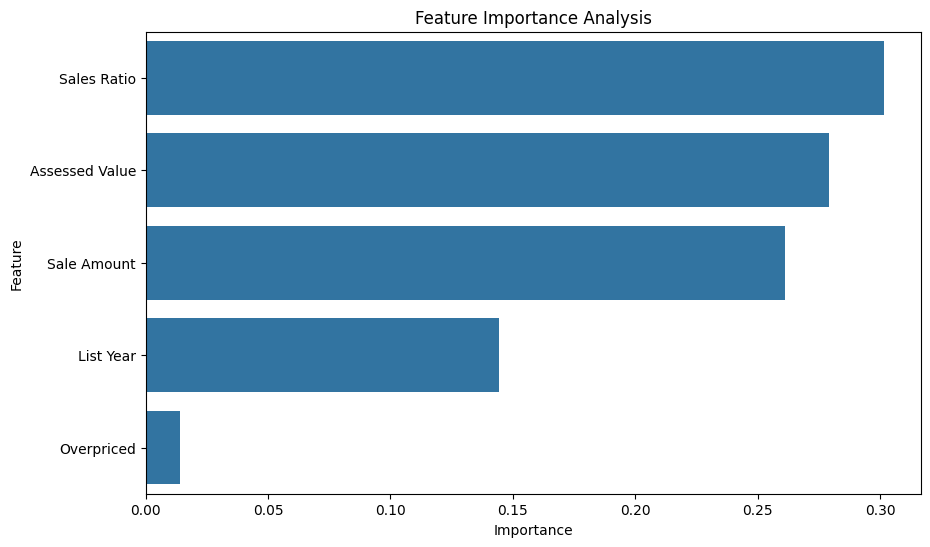

In [29]:
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title("Feature Importance Analysis")
plt.show()

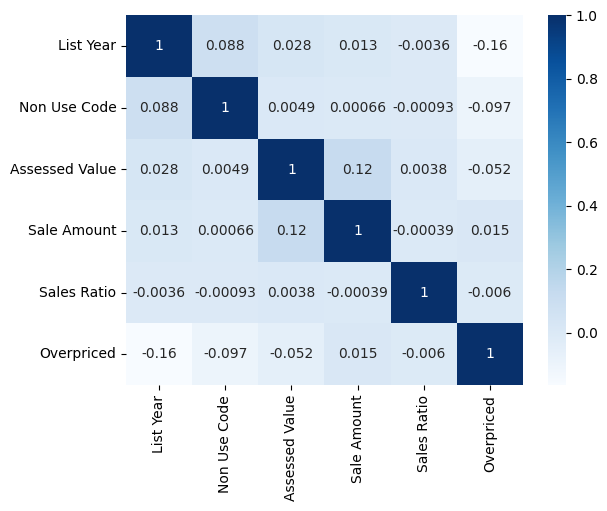

In [30]:
matrix = real_estate4.corr()

sns.heatmap(matrix, annot=True, cmap='Blues')
plt.show()